# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Elyzia Janara Khansa
- **Email:** elyziajanarakhansa@gmail.com
- **ID Dicoding:** elyzia

## Menentukan Pertanyaan Bisnis

1. Bagaimana tren penjualan dalam enam bulan terakhir?
2. Produk mana yang paling sering dibeli oleh pelanggan?

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Wrangling

### Gathering Data

In [2]:
dataset_paths = {
    "customers": 'dashboard/data/customers_dataset.csv',
    "geolocation": 'dashboard/data/geolocation_dataset.csv',
    "order_items": 'dashboard/data/order_items_dataset.csv',
    "order_payments": 'dashboard/data/order_payments_dataset.csv',
    "order_reviews": 'dashboard/data/order_reviews_dataset.csv',
    "orders": 'dashboard/data/orders_dataset.csv',
    "product_translation": 'dashboard/data/product_category_name_translation.csv',
    "products": 'dashboard/data/products_dataset.csv',
    "sellers": 'dashboard/data/sellers_dataset.csv'
}

datasets = {name: pd.read_csv(path) for name, path in dataset_paths.items()}

print(datasets["order_reviews"].isnull().sum())

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


**Insight:**
- Data berhasil di-load dari berbagai sumber.
- Dataset terdiri dari informasi pelanggan, produk, pembayaran, penjual, dan pesanan.


### Assessing Data

In [3]:
for name, df in datasets.items():
    print(f"{name}: {df.shape[0]} baris, {df.shape[1]} kolom")


customers: 99441 baris, 5 kolom
geolocation: 1000163 baris, 5 kolom
order_items: 112650 baris, 7 kolom
order_payments: 103886 baris, 5 kolom
order_reviews: 99224 baris, 7 kolom
orders: 99441 baris, 8 kolom
product_translation: 71 baris, 2 kolom
products: 32951 baris, 9 kolom
sellers: 3095 baris, 4 kolom


In [4]:
for name, df in datasets.items():
    print(f"{name}: {df.isnull().sum().sum()} missing values")

customers: 0 missing values
geolocation: 0 missing values
order_items: 0 missing values
order_payments: 0 missing values
order_reviews: 145903 missing values
orders: 4908 missing values
product_translation: 0 missing values
products: 2448 missing values
sellers: 0 missing values


- Beberapa dataset memiliki missing values yang perlu ditangani.
- Data memiliki banyak entitas yang saling berhubungan.


### Cleaning Data

In [5]:
df = datasets["orders"].merge(datasets["customers"], on='customer_id', how='left')
df = df.merge(datasets["order_items"], on='order_id', how='left')
df = df.merge(datasets["products"], on='product_id', how='left')
df = df.merge(datasets["sellers"], on='seller_id', how='left')
df = df.merge(datasets["order_payments"], on='order_id', how='left')
df = df.merge(datasets["order_reviews"], on='order_id', how='left')

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df.fillna({'payment_value': 0}, inplace=True)
df.drop(columns=['customer_unique_id', 'seller_zip_code_prefix'], inplace=True)


**Insight:**
- Kolom tanggal dikonversi ke format datetime.
- Missing values di kolom payment_value diisi dengan 0.
- Kolom yang tidak relevan telah dihapus.

## Exploratory Data Analysis (EDA)

### Tren Penjualan Per Bulan

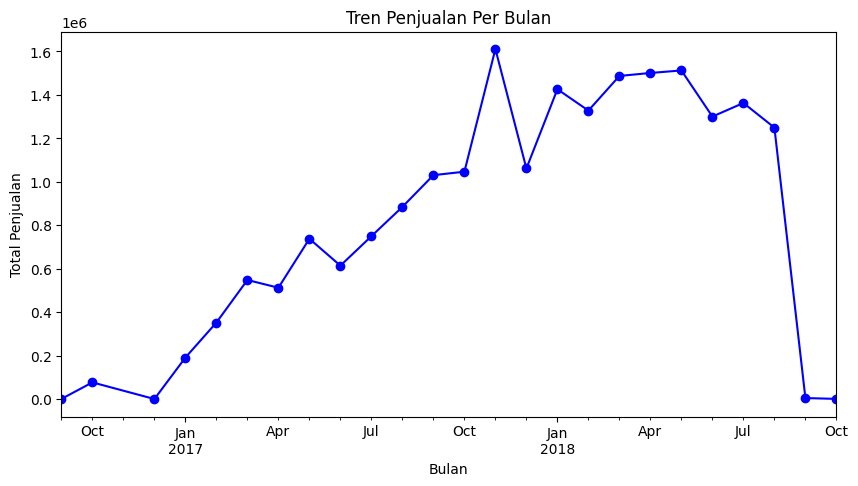

In [6]:
## Tren Penjualan Per Bulan
sales_trend = df.groupby(df['order_purchase_timestamp'].dt.to_period("M"))['payment_value'].sum()

plt.figure(figsize=(10,5))
sales_trend.plot(kind='line', marker='o', color='b')
plt.title("Tren Penjualan Per Bulan")
plt.xlabel("Bulan")
plt.ylabel("Total Penjualan")
plt.show()

**Insight:**
- Terlihat adanya fluktuasi tren penjualan bulanan.
- Bisa dianalisis lebih lanjut untuk melihat faktor yang mempengaruhi tren ini.


### Produk Terlaris

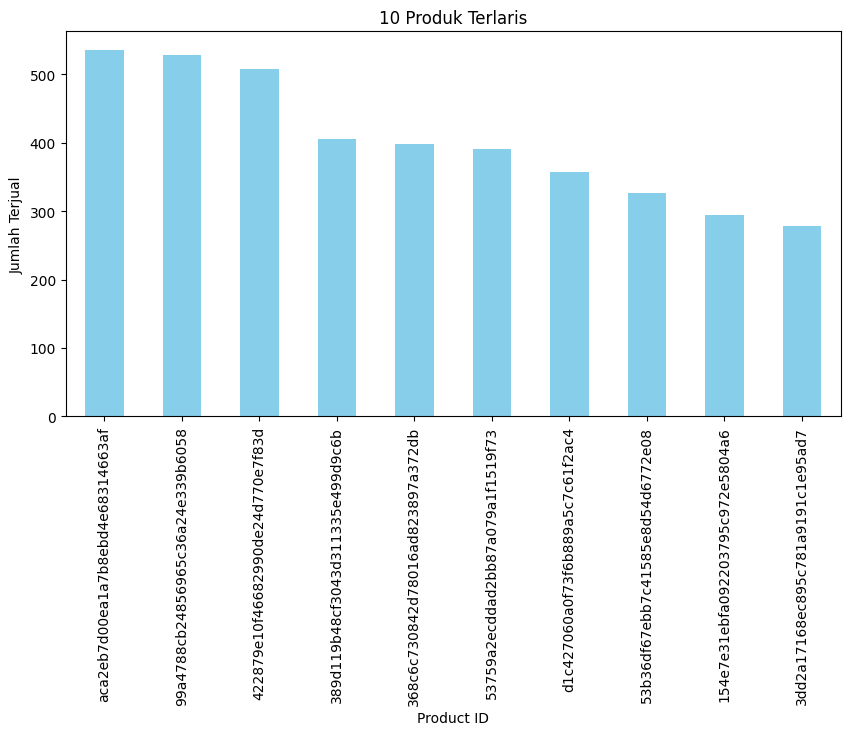

In [7]:
## Produk Terlaris
top_products = df.groupby('product_id')['order_item_id'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_products.plot(kind='bar', color='skyblue')
plt.title("10 Produk Terlaris")
plt.xlabel("Product ID")
plt.ylabel("Jumlah Terjual")
plt.show()

**Insight:**
- Produk-produk dengan jumlah transaksi terbanyak dapat dianalisis lebih lanjut.
- Bisa digunakan untuk strategi pemasaran dan pengadaan stok.


### Distribusi Jumlah Pembayaran

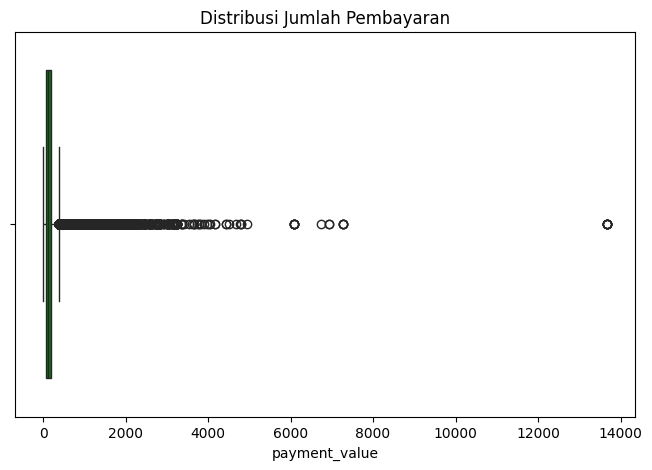

In [8]:
## Distribusi Jumlah Pembayaran
plt.figure(figsize=(8,5))
sns.boxplot(x=df['payment_value'], color='green')
plt.title("Distribusi Jumlah Pembayaran")
plt.show()


**Insight:**
- Terdapat beberapa nilai pembayaran yang jauh lebih tinggi dari lainnya (outlier).
- Bisa dianalisis lebih lanjut untuk mendeteksi transaksi yang mencurigakan.


## Visualization & Explanatory Analysis

### Pertanyaan 1:

In [9]:
## RFM Analysis
snapshot_date = df['order_purchase_timestamp'].max()
rfm = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
print(rfm.describe())

            Recency     Frequency       Monetary
count  99441.000000  99441.000000   99441.000000
mean     289.900192      1.198128     206.953510
std      153.667316      0.751055     622.550183
min        0.000000      1.000000       0.000000
25%      166.000000      1.000000      62.960000
50%      271.000000      1.000000     110.240000
75%      400.000000      1.000000     196.520000
max      772.000000     63.000000  109312.640000


**Insight:**
- Rata-rata pelanggan terakhir melakukan transaksi dalam rentang tertentu.
- Frekuensi dan nilai transaksi juga bisa digunakan untuk segmentasi pelanggan.

### Pertanyaan 2:

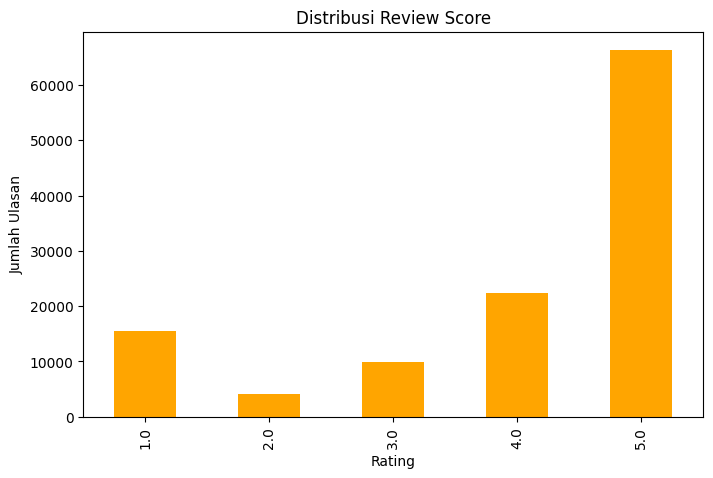

In [10]:
## Distribusi Review Score
plt.figure(figsize=(8,5))
df['review_score'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title("Distribusi Review Score")
plt.xlabel("Rating")
plt.ylabel("Jumlah Ulasan")
plt.show()

**Insight:**
- Mayoritas ulasan memiliki skor tertentu, bisa menjadi bahan evaluasi kualitas layanan.
- Bisa dianalisis lebih lanjut untuk memahami faktor yang mempengaruhi skor ulasan.

